In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from prepare import build_vocab
from models import RecurrentModel, VanillaRNNBlock
from nameTrainer import NameTrainer
from generateName import generate_name

# Загрузка и анализ данных (#2)

In [4]:
df = pd.read_csv(r'data/babynames-clean.csv', header=None)
df.columns = ['name', "gender"]

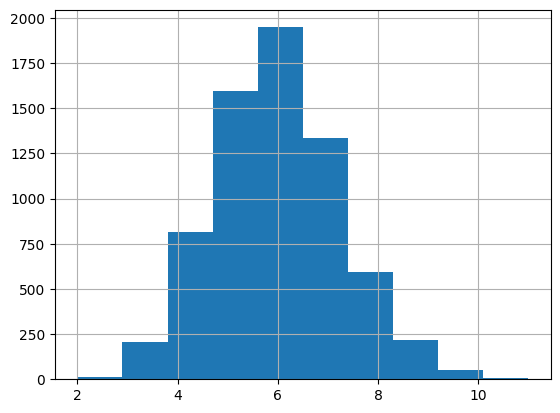

In [17]:
df.name.str.len().hist();

In [6]:
df.gender.value_counts()/df.shape[0]*100

gender
boy     50.678266
girl    49.321734
Name: count, dtype: float64

In [10]:
cleaned = df.name.str.strip()
cleaned = df.name.str.lower()

In [13]:
cleaned.str.split("").explode().value_counts()

name
     13564
a     5593
e     5038
n     3524
i     3264
l     3255
r     3070
o     2071
t     1745
s     1674
d     1532
m     1245
y     1243
h     1206
c     1063
u      707
b      673
k      616
g      526
j      502
v      490
f      302
w      271
p      265
z      199
x       71
q       61
Name: count, dtype: int64

# Подготовка данных (№3)

In [14]:
df.gender = (df.gender == "boy")*1

In [21]:
with_tokens = [f"<{name}>" for name in cleaned]
max_len = max(len(s) for s in with_tokens)
padded = [s.ljust(max_len, ' ') for s in with_tokens]

In [22]:
max_len

13

In [33]:
tokens, token2id, id2token = build_vocab(padded)

In [24]:
encoded = np.zeros((len(padded), max_len), dtype=np.int64)
    
for i, name in enumerate(padded):
    encoded[i] = [token2id[ch] for ch in name]

In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(
    encoded, df.gender, test_size=0.2, random_state=42, stratify=df.gender
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Vanilla RNN

In [35]:
model = RecurrentModel(
    vocab_size=len(tokens),
    embedding_dim=64,
    hidden_size=128,
    rnn_block_cls=VanillaRNNBlock,
    dropout_p=0.1,
)

In [49]:
for temp in [0.7, 1.0, 1.3]:
    print(f"\nTemperature = {temp}")
    for _ in range(5):
        print(generate_name(model, token2id, id2token,
                            start_text="", max_len=13,
                            temperature=temp))


Temperature = 0.7
iedlvzecs
teqxtkzh
oeculxktklute
kowbbrraqnev
ix

Temperature = 1.0
pkglvoaojqnpk
bqzvcbbnlirq 
xuvo
wbhuifbctye
aaxraj

Temperature = 1.3
pdamysld
p biqlf
blxplmdzivehz
nhztgjraivju
oxlwimlgjhqyh


In [43]:
trainer_next = NameTrainer(
    model,
    device="cuda",
    use_next_char_loss=True,
    use_gender_loss=False,
    alpha=1.0,
    beta=0.0,
)
trainer_gender = NameTrainer(
    model,
    device="cuda",
    use_next_char_loss=False,
    use_gender_loss=True,
    alpha=0.0,
    beta=1.0,
)

In [ ]:
trainer_next